## Burgers' Equation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Problem

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

def show_result(t, x, U, title=""):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3))
    for idx in (0, 25, 50, 75, -1):
        ax1.plot(x, U[idx, :], label=f't={t[idx]:.2f}')
    ax1.set(xlabel='x', ylabel='u(t, x)', title=title)
    ax1.legend(loc="upper right", fontsize=8, frameon=False)
    ax1.grid(color='k', ls=':', lw=.5)

    img = ax2.imshow(U, cmap='rainbow', aspect='auto', interpolation='bilinear',
                    vmin=np.round(U.min()), vmax=np.round(U.max()),
                    origin='lower', extent=(x.min(), x.max(), t.min(), t.max()))
    ax2.set(xlabel='x', ylabel='t', title=title)
    fig.colorbar(img, ax=ax2)
    fig.tight_layout()
    plt.show()

In [3]:
import scipy

data = scipy.io.loadmat('data/burgers_shock.mat')
t = data['t'].flatten()     # (100,)
x = data['x'].flatten()     # (256,)
U_data = data['usol'].T     # (100, 256)

In [4]:
t_min, t_max, t_size = t.min(), t.max(), t.size     # (0, 0.99, 100)
x_min, x_max, x_size = x.min(), x.max(), x.size     # (-1, 1, 256)

# t = np.linspace(t_min, t_max, t_size)       # (t_size,)
# x = np.linspace(x_min, x_max, x_size)       # (x_size,)
T, X = np.meshgrid(t, x, indexing="ij")     # (t_size, x_size)

print(t_min, t_max, t_size)
print(x_min, x_max, x_size)

0.0 0.99 100
-1.0 1.0 256


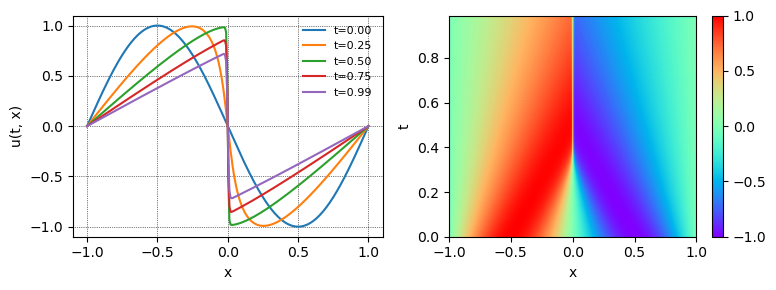

In [5]:
show_result(t, x, U_data)

In [ ]:
from pyDOE import lhs       # Latin Hypercube Sampling

def to_tensor(x):
    return torch.tensor(x).float().view(-1, 1).to(device)

def to_array(x):
    return x.view(-1).cpu().detach().numpy()

n_pde, n_ic, n_bc = 2000, 256, 100

set_seed(42)
## Domain: u_t + u*u_x - (0.01/np.pi)*u_xx
lb, ub = np.array([t_min, x_min]), np.array([t_max, x_max])
points = lb + (ub - lb)*lhs(2, n_pde)
t_pde, x_pde = points[:, 0], points[:, 1]

## Initial condition: u(0, x) = -sin(pi * x)
x_ic = lhs(1, n_ic)*(x_max - x_min) + x_min
t_ic = np.full_like(x_ic, 0)
u_ic = -np.sin(np.pi * x_ic)

## Boundary condition: u(t, 0) = 0
t_bc1 = lhs(1, n_bc)*(t_max - t_min) + t_min
x_bc1 = np.full_like(t_bc1, x_min)
u_bc1 = np.full_like(t_bc1, 0)

## Boundary condition: u(t, x_max) = 0
t_bc2 = lhs(1, n_bc)*(t_max - t_min) + t_min
x_bc2 = np.full_like(t_bc2, x_max)
u_bc2 = np.full_like(t_bc2, 0)

## Convert numpy arrays to torch tensors
t_pde, x_pde = to_tensor(t_pde), to_tensor(x_pde)
t_ic, x_ic, u_ic = to_tensor(t_ic), to_tensor(x_ic), to_tensor(u_ic)
t_bc1, x_bc1, u_bc1 = to_tensor(t_bc1), to_tensor(x_bc1), to_tensor(u_bc1)
t_bc2, x_bc2, u_bc2 = to_tensor(t_bc2), to_tensor(x_bc2), to_tensor(u_bc2)

In [7]:
def gradient(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
                               create_graph=True, retain_graph=True)[0]

def residual_loss(model, t, x):
    t.requires_grad = True
    x.requires_grad = True

    u = model(t, x)
    u_t = gradient(u, t)
    u_x = gradient(u, x)
    u_xx = gradient(u_x, x)

    residual = u_t + u*u_x - (0.01/np.pi)*u_xx
    return torch.mean(residual**2)

def mse_loss(model, t, x, u):
    u_pred = model(t, x)
    return torch.mean((u_pred - u)**2)

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),  nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1),
        )

    def forward(self, t, x):
        tx = torch.hstack([t, x])
        return self.net(tx)

In [8]:
## Training
n_epochs = 10000
learning_rate = 1e-3

model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.985)

for epoch in range(1, n_epochs + 1):
    model.train()
    loss_pde = residual_loss(model, t_pde, x_pde)
    loss_ic = mse_loss(model, t_ic, x_ic, u_ic)
    loss_bc1 = mse_loss(model, t_bc1, x_bc1, u_bc1)
    loss_bc2 = mse_loss(model, t_bc2, x_bc2, u_bc2)

    loss = loss_pde + loss_ic + loss_bc1 + loss_bc2
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % (n_epochs // 10) == 0:
        print(f"[{epoch:5d}/{n_epochs}] (lr: {scheduler.get_last_lr()[0]:.2e}) "
              f"loss: {loss.item():.2e} "
              f"(pde: {loss_pde.item():.2e} ic: {loss_ic.item():.2e} "
              f"bc1: {loss_bc1.item():.2e} bc2: {loss_bc2.item():.2e})")

/home/nam/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[ 1000/10000] (lr: 8.60e-04) loss: 7.82e-02 (pde: 3.29e-02 ic: 4.47e-02 bc1: 2.80e-04 bc2: 3.27e-04)
[ 2000/10000] (lr: 7.39e-04) loss: 4.94e-02 (pde: 2.08e-02 ic: 2.82e-02 bc1: 2.14e-04 bc2: 1.24e-04)
[ 3000/10000] (lr: 6.35e-04) loss: 3.32e-02 (pde: 1.32e-02 ic: 1.98e-02 bc1: 1.39e-04 bc2: 8.70e-05)
[ 4000/10000] (lr: 5.46e-04) loss: 2.08e-02 (pde: 8.92e-03 ic: 1.17e-02 bc1: 1.29e-04 bc2: 2.51e-05)
[ 5000/10000] (lr: 4.70e-04) loss: 1.09e-02 (pde: 6.47e-03 ic: 4.29e-03 bc1: 1.37e-04 bc2: 2.60e-05)
[ 6000/10000] (lr: 4.04e-04) loss: 6.56e-03 (pde: 4.42e-03 ic: 1.99e-03 bc1: 1.26e-04 bc2: 2.97e-05)
[ 7000/10000] (lr: 3.47e-04) loss: 3.63e-03 (pde: 2.31e-03 ic: 1.27e-03 bc1: 3.40e-05 bc2: 1.77e-05)
[ 8000/10000] (lr: 2.98e-04) loss: 2.30e-03 (pde: 1.50e-03 ic: 7.54e-04 bc1: 3.19e-05 bc2: 1.49e-05)
[ 9000/10000] (lr: 2.57e-04) loss: 1.64e-03 (pde: 1.03e-03 ic: 5.85e-04 bc1: 1.70e-05 bc2: 6.96e-06)
[10000/10000] (lr: 2.21e-04) loss: 1.24e-03 (pde: 7.61e-04 ic: 4.63e-04 bc1: 1.39e-05 bc2: 

In [9]:
n_epochs = 10000
learning_rate = 1e-4

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.985)

for epoch in range(1, n_epochs + 1):
    model.train()
    loss_pde = residual_loss(model, t_pde, x_pde)
    loss_ic = mse_loss(model, t_ic, x_ic, u_ic)
    loss_bc1 = mse_loss(model, t_bc1, x_bc1, u_bc1)
    loss_bc2 = mse_loss(model, t_bc2, x_bc2, u_bc2)

    loss = loss_pde + loss_ic + loss_bc1 + loss_bc2
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % (n_epochs // 10) == 0:
        print(f"[{epoch:5d}/{n_epochs}] (lr: {scheduler.get_last_lr()[0]:.2e}) "
              f"loss: {loss.item():.2e} "
              f"(pde: {loss_pde.item():.2e} ic: {loss_ic.item():.2e} "
              f"bc1: {loss_bc1.item():.2e} bc2: {loss_bc2.item():.2e})")

[ 1000/10000] (lr: 8.60e-05) loss: 1.15e-03 (pde: 6.99e-04 ic: 4.34e-04 bc1: 1.11e-05 bc2: 4.02e-06)
[ 2000/10000] (lr: 7.39e-05) loss: 1.03e-03 (pde: 6.35e-04 ic: 3.86e-04 bc1: 8.99e-06 bc2: 2.99e-06)
[ 3000/10000] (lr: 6.35e-05) loss: 9.27e-04 (pde: 5.76e-04 ic: 3.41e-04 bc1: 7.11e-06 bc2: 2.21e-06)
[ 4000/10000] (lr: 5.46e-05) loss: 8.49e-04 (pde: 5.35e-04 ic: 3.06e-04 bc1: 6.01e-06 bc2: 1.80e-06)
[ 5000/10000] (lr: 4.70e-05) loss: 7.75e-04 (pde: 4.91e-04 ic: 2.77e-04 bc1: 4.67e-06 bc2: 1.45e-06)
[ 6000/10000] (lr: 4.04e-05) loss: 7.18e-04 (pde: 4.58e-04 ic: 2.55e-04 bc1: 3.84e-06 bc2: 1.25e-06)
[ 7000/10000] (lr: 3.47e-05) loss: 6.77e-04 (pde: 4.37e-04 ic: 2.35e-04 bc1: 3.41e-06 bc2: 1.14e-06)
[ 8000/10000] (lr: 2.98e-05) loss: 6.50e-04 (pde: 4.26e-04 ic: 2.20e-04 bc1: 2.56e-06 bc2: 1.21e-06)
[ 9000/10000] (lr: 2.57e-05) loss: 5.84e-04 (pde: 3.76e-04 ic: 2.05e-04 bc1: 2.08e-06 bc2: 9.77e-07)
[10000/10000] (lr: 2.21e-05) loss: 5.48e-04 (pde: 3.53e-04 ic: 1.93e-04 bc1: 1.69e-06 bc2: 

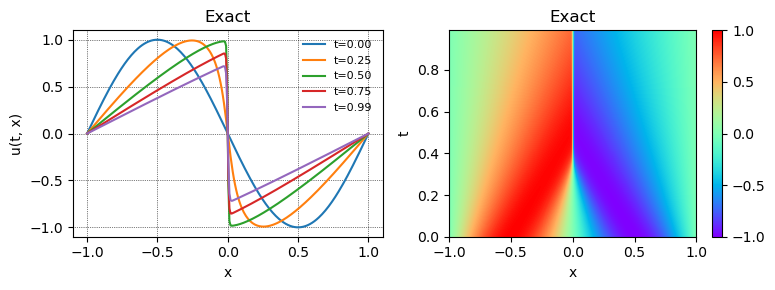

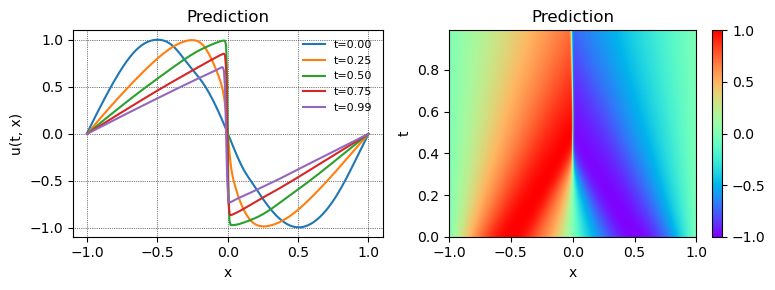

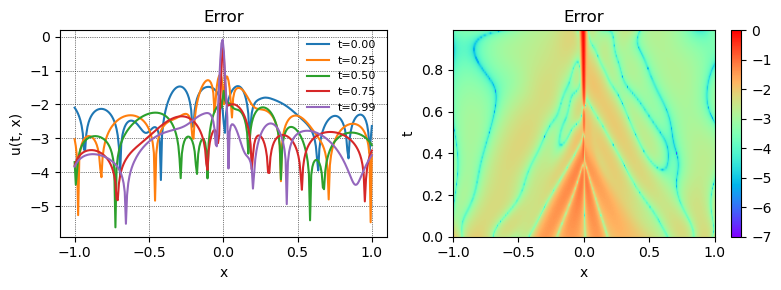

In [10]:
## Evaluation
with torch.no_grad():
    t_test, x_test = to_tensor(T.flatten()), to_tensor(X.flatten())
    U_pred = model(t_test, x_test)

U_pred = to_array(U_pred).reshape(t_size, x_size)

show_result(t, x, U_data, title="Exact")
show_result(t, x, U_pred, title="Prediction")
show_result(t, x, np.log10(abs(U_data - U_pred)), title="Error")